# Введение

Реализация проекта сегментации радиографических снимков легких человека.

Проект посвящён аугментации изображений здоровых лёгких для увеличения объёма данных и повышения точности моделей сегментации.

In [ ]:
!pip install opendatasets

# Импорт библиотек

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img, img_to_array                         # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса



import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Загрузка и подготовка датасета

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Alexandrrrr
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:07<00:00, 111MB/s]


In [ ]:
dataset_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

## Функция для отображения

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная ма.ска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)                # маска с прозрачностью 50%
    plt.axis('off')
  plt.show()

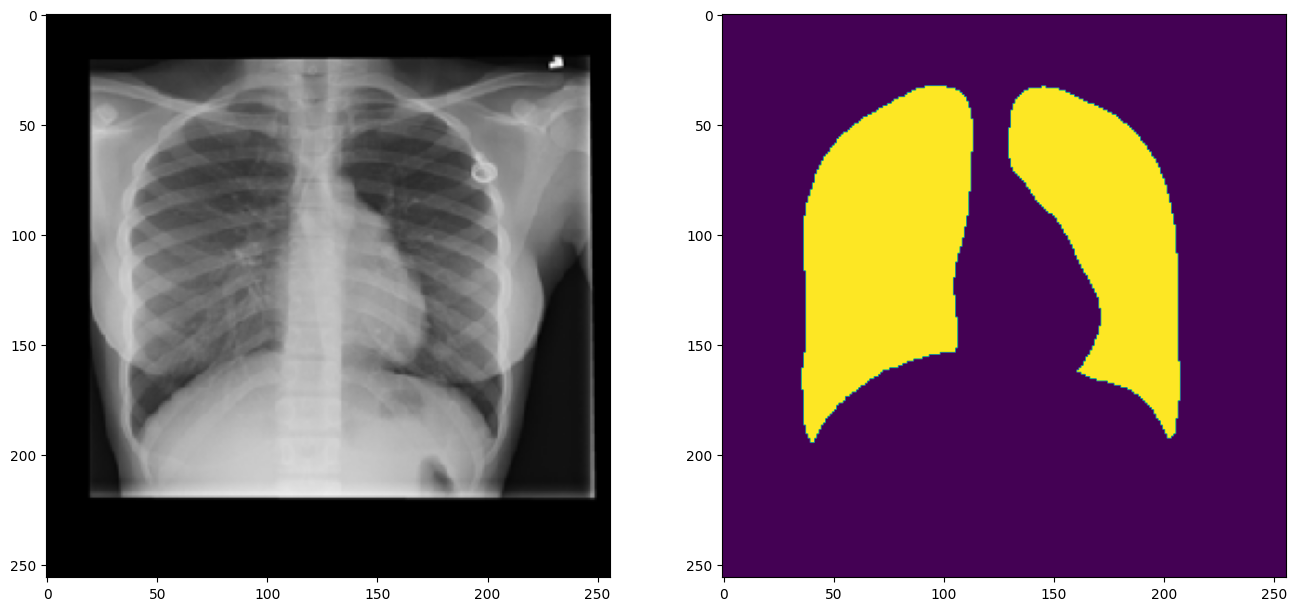

In [ ]:
images = os.path.join(dataset_path, image_dir, 'Normal-1.png')                        # путь до ориганального изображения
masks = os.path.join(dataset_path, label_dir, 'Normal-1.png')                         # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

img = np.array(load_img(images, target_size=(256, 256), color_mode='rgb'))
mask = np.array(load_img(masks, target_size=(256, 256), color_mode='grayscale'))

axs[0].imshow(img)                                                                    # оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask)                                                                   # маска
axs[1].grid(False)

## Константы

In [ ]:
IMG_SIZE = (256, 256)
NUM_CLASSES = 2
batch_size = 16
seed = 1523
val_samples = 1000
img_size = IMG_SIZE
num_classes = NUM_CLASSES
epochs = 5

## Сортировка

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

# Генерация данных

In [ ]:
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size,
                 img_size,
                 input_img_path,
                 target_img_path = None,
                 num_classes = NUM_CLASSES,
                 validation = False,
                 **kwargs):
        super().__init__(**kwargs)                                                    # вызов конструктора базового класса
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.num_classes = num_classes
        self.validation = validation

    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size

    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype="uint8")

        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([                                               # функция аугментации
                              A.Flip(p=0.5),                                          # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5)           # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask)                         # примение функции аугментации к изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255.0                                                        # нормализация изображения
            mask[mask > self.num_classes - 1] = self.num_classes - 1                  # исправление значение маски
            y[_] = to_categorical(mask, num_classes=self.num_classes)                 # конвертирование маски в категориальный формат

        return x, y

In [ ]:
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

## trin-val

In [ ]:
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

In [ ]:
train_gen = datasetGenerator(batch_size,
                             img_size,
                             train_input_img_path,
                             train_target_img_path,
                             num_classes)

val_gen = datasetGenerator(batch_size,
                           img_size,
                           val_input_img_path,
                           val_target_img_path,
                           num_classes,
                           validation = True)

# Функция для свертки

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

# Encoder - Decoder

In [ ]:
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)                            # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)                                  # зеленый блок
    return encod1, MaxPool1                                                           # функция возвращает латеральное соединение и выход из слоя

# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters,
                               (2, 2),
                               strides=2,
                               padding="same")(entered_input)                                        # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                    # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                # функция свертки - 2 синих блока
    return out                                                                        # функция возвращает выход из слоя

# Сastom U-net

In [ ]:
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышко
    conv_block = convolution_operation(encoder_4, 64*16)

    # Блоки декодировщика
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок)
    outputs = Conv2D(num_classes,
                     kernel_size = (1, 1),
                     padding="same",
                     activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)                                           # размер к которому преобразуется изображение
model = U_Net(input_shape, num_classes)                                               # инициализация модели

# Компиляция модели

In [ ]:
model.compile(
    optimizer='adam' ,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras",
                                    monitor='val_loss',
                                    save_best_only=True)
]

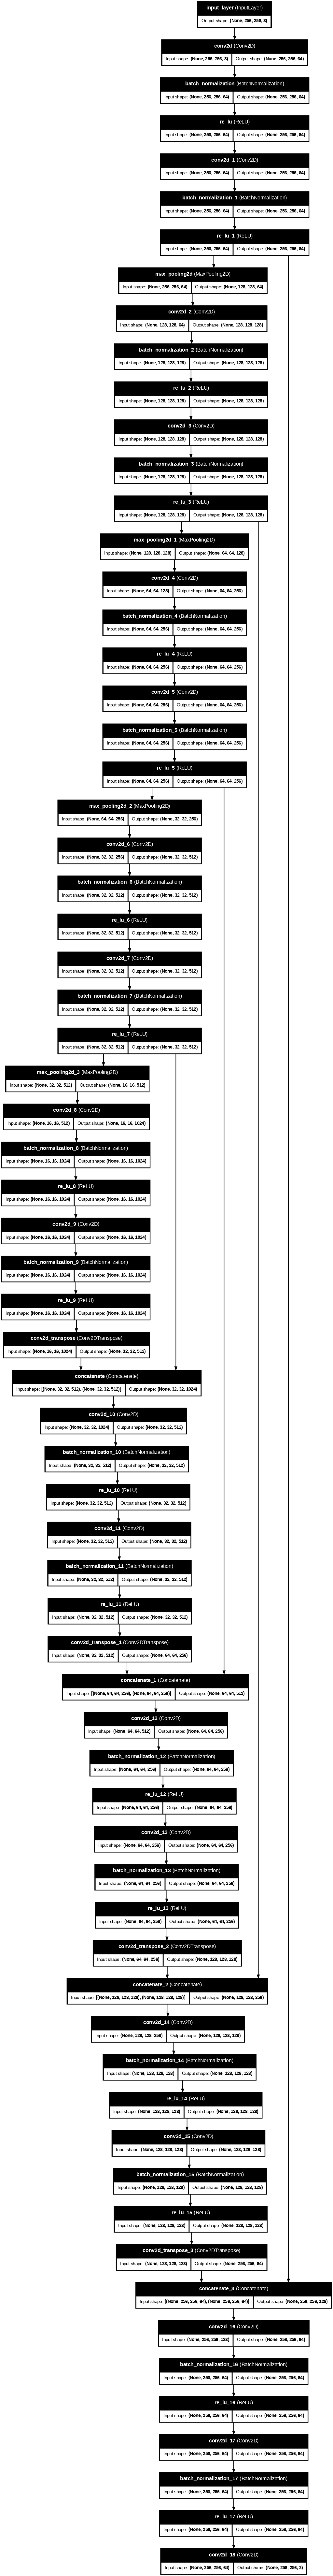

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png",
                          show_shapes=True,
                          show_dtype=False,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=False,
                          dpi=70)

# Обучение модели

In [ ]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

<ipython-input-12-cd80b6dc5534>:38: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),                                          # Отражение изображения по горизонтали и вертикали


Epoch 1/5
574/574 ━━━━━━━━━━━━━━━━━━━━ 621s 932ms/step - accuracy: 0.9363 - loss: 0.1588 - val_accuracy: 0.9799 - val_loss: 0.0558
Epoch 2/5
574/574 ━━━━━━━━━━━━━━━━━━━━ 533s 906ms/step - accuracy: 0.9886 - loss: 0.0298 - val_accuracy: 0.9895 - val_loss: 0.0274
Epoch 3/5
574/574 ━━━━━━━━━━━━━━━━━━━━ 512s 890ms/step - accuracy: 0.9914 - loss: 0.0221 - val_accuracy: 0.9895 - val_loss: 0.0291
Epoch 4/5
574/574 ━━━━━━━━━━━━━━━━━━━━ 512s 891ms/step - accuracy: 0.9929 - loss: 0.0179 - val_accuracy: 0.9862 - val_loss: 0.0445
Epoch 5/5
574/574 ━━━━━━━━━━━━━━━━━━━━ 569s 903ms/step - accuracy: 0.9931 - loss: 0.0172 - val_accuracy: 0.9906 - val_loss: 0.0243


# Графики точности и потерь

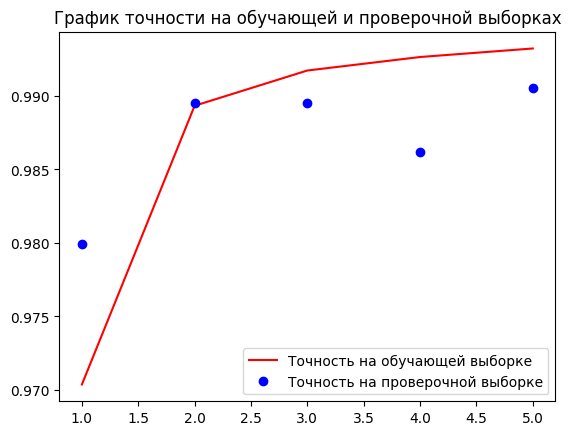

In [ ]:
acc = history.history['accuracy']                                                     # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                                             # данные о точности на проверочной выборке
loss = history.history['loss']                                                        # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                                # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                                       # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')                     # график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')              # график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')                      # заголовок графика
plt.legend()                                                                          # легенда графика

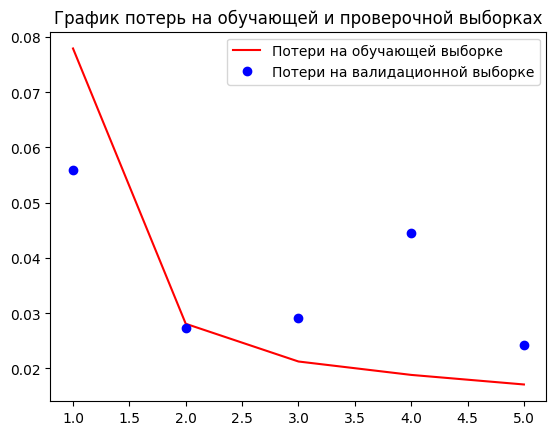

In [ ]:
plt.figure()
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')                      # график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')             # график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')                        # заголовок графика
plt.legend()                                                                          # легенда графика
plt.show()

# Визуализация резльутатов

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])
    plt.imshow(display_list[i],alpha=0.8)
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


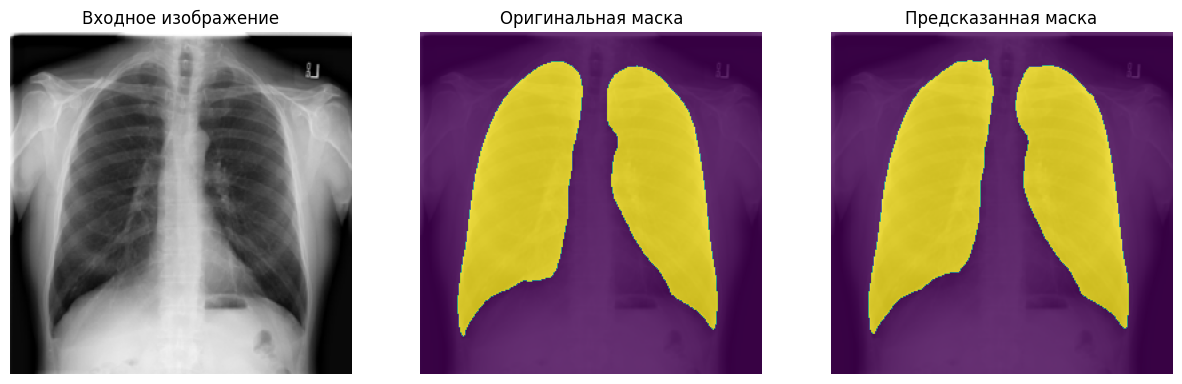

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


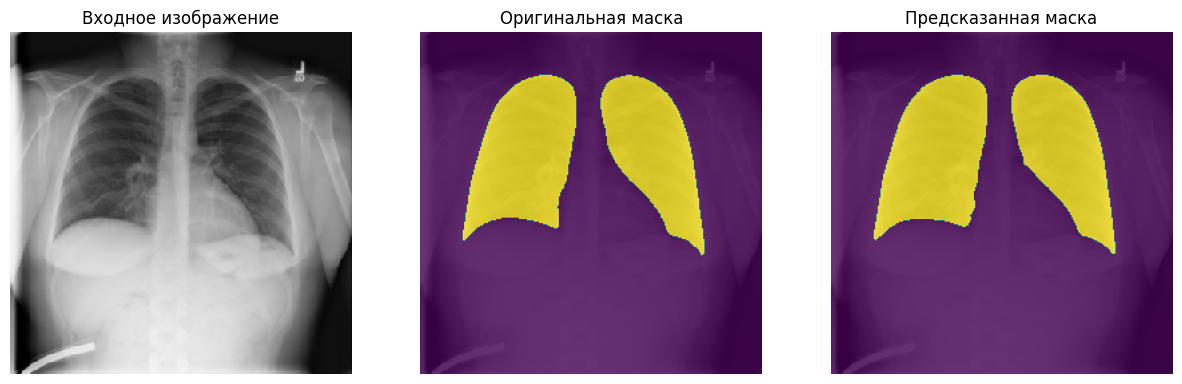

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


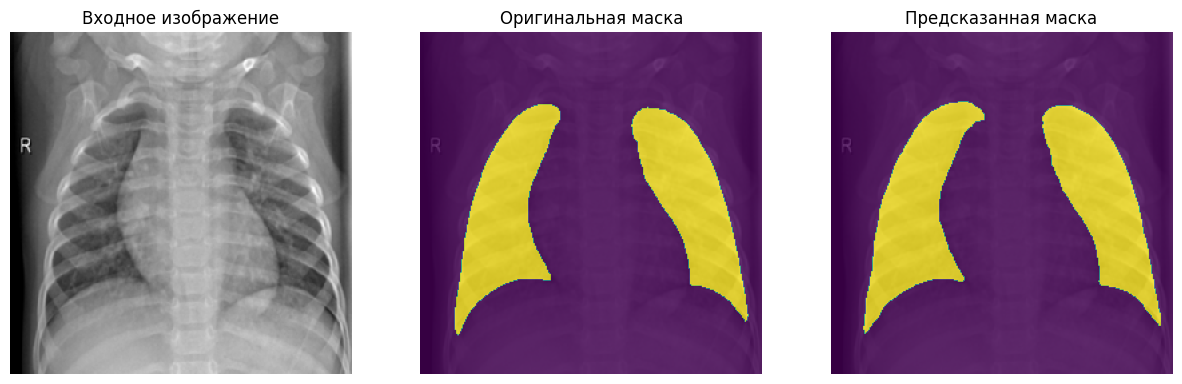

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


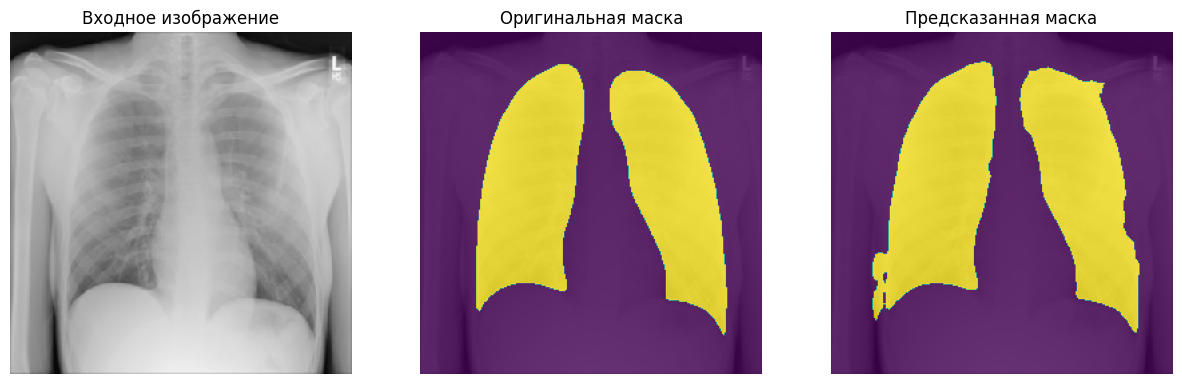

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


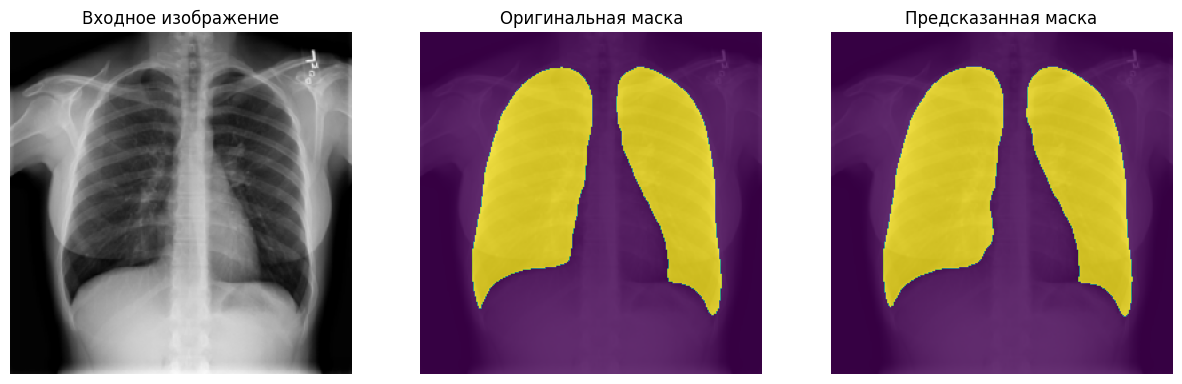

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


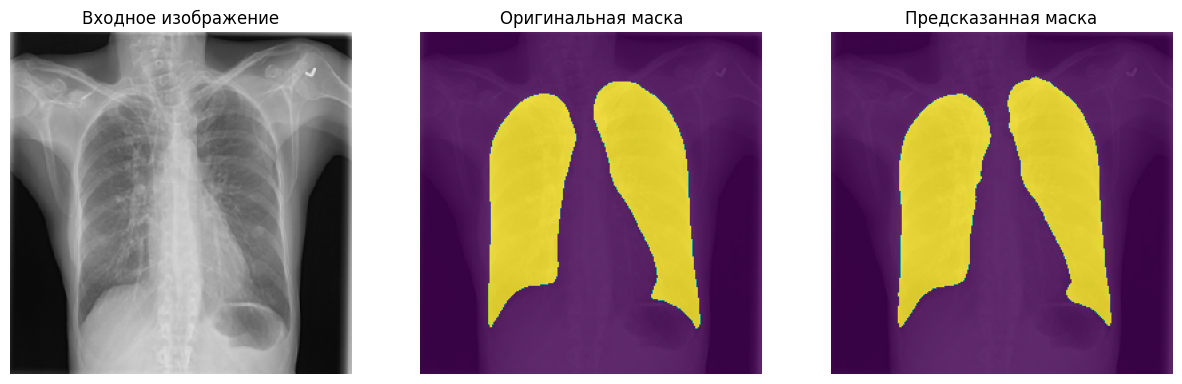

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


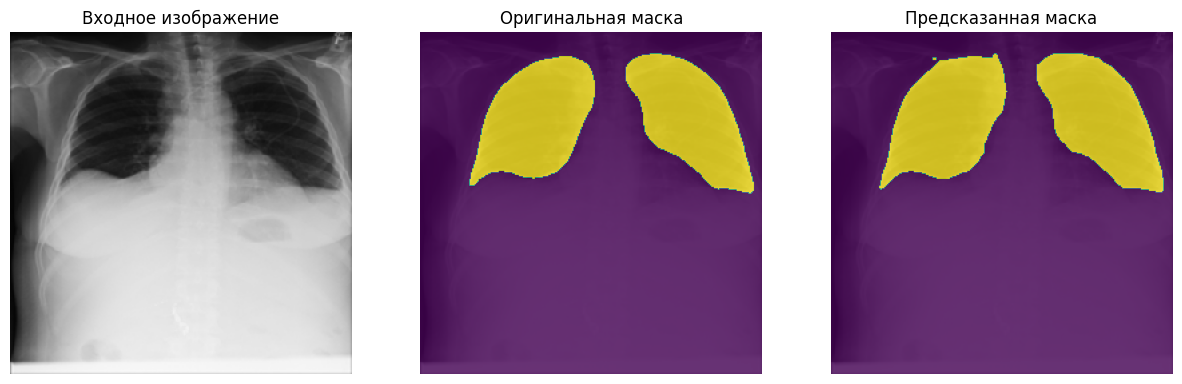

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


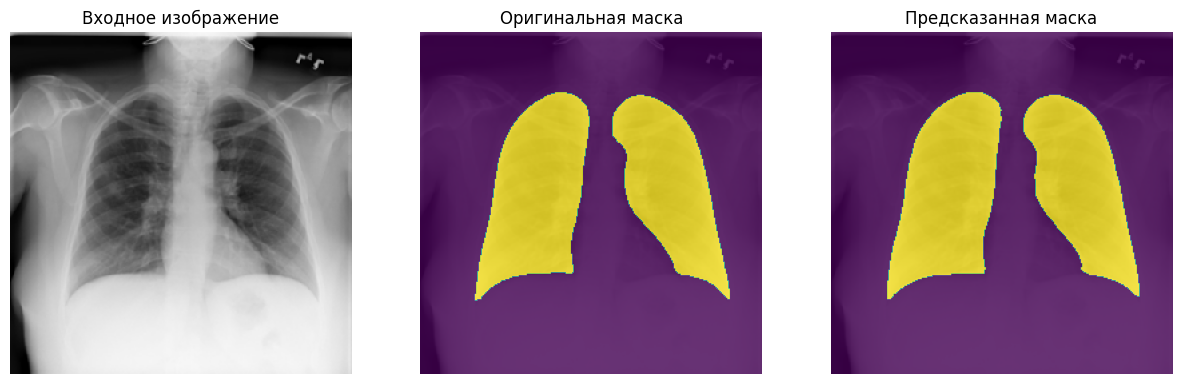

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


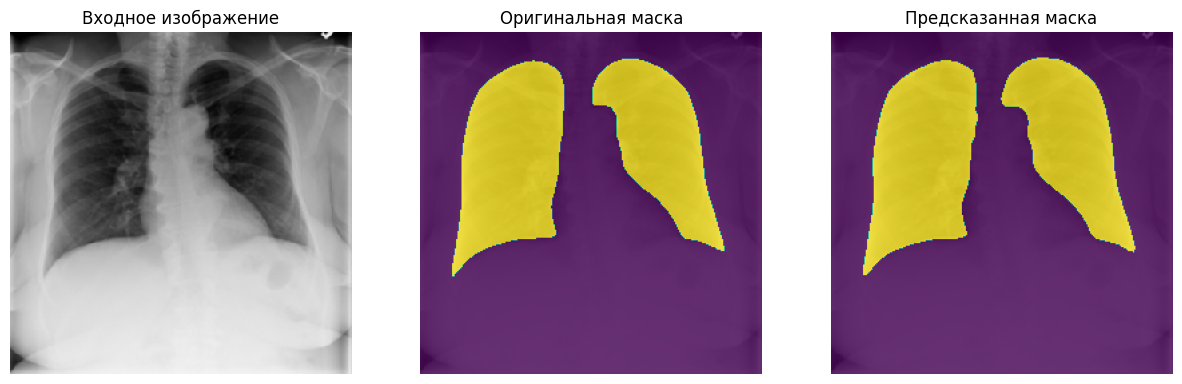

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


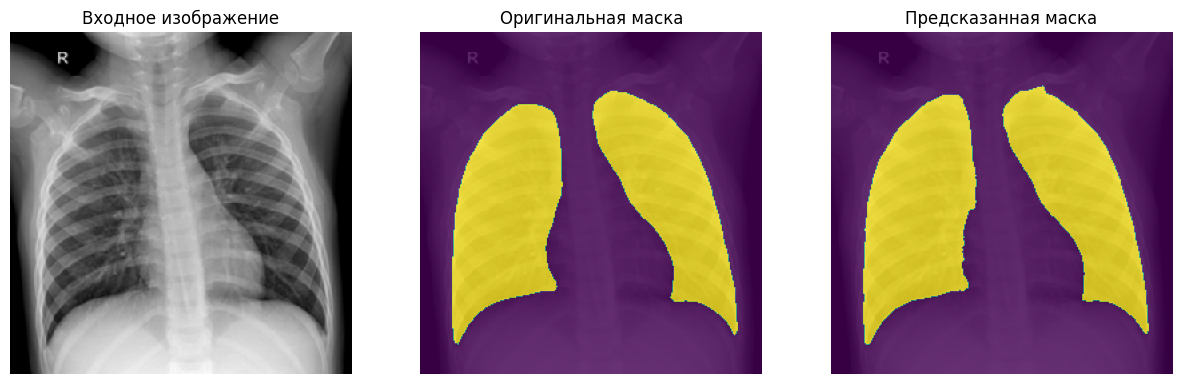

In [ ]:
for index in range(10):
    img = np.array(load_img(val_input_img_path[index],
                            target_size=(256, 256),
                            color_mode='rgb'))                                        # картинка для предсказания
    mask = np.array(load_img(val_target_img_path[index],
                             target_size=(256, 256),
                             color_mode='grayscale'))                                 # маска для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])